# 0. Importación de librerías y archivos

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import folium

# 1. Análisis exploratorio inicial

Importar archivos base

In [2]:
dataset = pd.read_csv(r'datasets\full_dataset\v1\all_weeks.csv')

discarded = [
    'pistas_asfaltadas',
    'pistas_empedradas',
    'pistas_tierra',
    'veredas_concreto',
    'escaleras_concreto',
    'agua_procedencia_2',
    'conexión_sanitario_2',
    'vivienda_piso',
    'tipo_envase',
    'tapa_agua'
]

dataset.drop(columns=discarded, inplace=True)
dataset = dataset.loc[dataset['Semana']<19,:]

dataset['pluvio_prom'] = (dataset['pluvio_max'] + dataset['pluvio_min'])/2
dataset['temp_prom'] =  (dataset['temp_max'] + dataset['temp_min'])/2
dataset['viento_prom'] = (dataset['viento_max'] + dataset['viento_min'])/2

dataset.drop(columns=['pluvio_min','pluvio_max','temp_min','temp_max','viento_min','viento_max'],inplace=True)
dataset

,Año,Semana,Ubigeo,casos,presión,humedad,agua_procedencia_1,conexión_sanitario_1,satisf_barrido,satisf_basura,...,vivienda_pared,vivienda_techo,prueba_cloro,indice_riqueza,sanitario_compartido,purificacion_agua,conserva_agua,pluvio_prom,temp_prom,viento_prom
0,2021,1,150102,0.0,1012.0,19.0,1,1,3,3,...,2,1,1,2,0.076923,0.961538,1.000000,0.0,22.000000,7.0
1,2021,1,150103,0.0,1015.0,18.0,1,1,3,3,...,2,1,1,3,0.138614,0.990196,1.000000,0.0,21.000000,8.0
2,2021,1,150104,0.0,1012.0,19.0,1,1,3,3,...,2,1,1,3,0.111111,1.000000,0.948470,0.0,21.666667,10.0
3,2021,1,70102,0.0,1012.0,19.0,1,1,3,2,...,2,1,1,4,0.053030,0.954545,0.945205,0.0,21.000000,12.0
4,2021,1,150105,0.0,1013.0,19.0,1,1,2,3,...,2,1,0,4,0.115385,1.000000,1.000000,0.0,22.000000,10.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,2024,18,150140,57.0,1011.0,17.0,1,1,3,3,...,2,1,1,4,0.074957,0.987230,0.968869,0.0,21.500000,10.5
8696,2024,18,150141,10.0,1011.0,17.0,1,1,3,3,...,2,1,1,4,0.072039,0.989633,0.946162,0.0,22.000000,10.5
8697,2024,18,70106,296.0,1011.0,18.0,1,1,3,3,...,2,1,1,3,0.073895,0.978880,0.973292,0.0,20.500000,11.0
8698,2024,18,150142,74.0,1011.0,17.0,1,1,2,2,...,2,1,1,4,0.081151,0.988161,0.962364,0.0,20.500000,11.5


In [3]:
only_casos = dataset.iloc[:,:4]
dataset2 = dataset.loc[dataset['casos']!=0]


# 2. Selección de atributos

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distributions(df):
    sns.set(style="whitegrid")

    num_vars = len(df.columns)

    fig, axes = plt.subplots(num_vars, 2, figsize=(12, num_vars*6))
    fig.tight_layout(pad=5.0)
    
    for i, column in enumerate(df.columns):
        sns.histplot(df[column], kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Histogram of {column}')
        skewness = df[column].skew()
        axes[i, 0].annotate(f'Skew: {skewness:.2f}', xy=(0.5, -0.15), xycoords='axes fraction', ha='center', fontsize=12)
        
        sns.boxplot(x=df[column], ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot of {column}')

    plt.show()
    plt.savefig('figura.pdf', format='pdf')
    
#plot_distributions(dataset)

In [5]:
dataset.drop(columns=['informacion_basura','pluvio_prom'],inplace=True)
dataset2.drop(columns=['informacion_basura','pluvio_prom'],inplace=True)

C:\Users\isosc\AppData\Local\Temp\ipykernel_15316\4146514325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset2.drop(columns=['informacion_basura','pluvio_prom'],inplace=True)


In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_dataframe(df, columns):

    for column in columns:
        skew_value = abs(df[column].skew())
        
        if skew_value < 0.6:
            scaler = StandardScaler()
        else:
            scaler = MinMaxScaler()
        
        df[column] = scaler.fit_transform(df[[column]])
    
    return df


dataset = scale_dataframe(dataset,['temp_prom','viento_prom','humedad','presión'])
dataset2 = scale_dataframe(dataset2,['temp_prom','viento_prom','humedad','presión'])

C:\Users\isosc\AppData\Local\Temp\ipykernel_15316\2788251332.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = scaler.fit_transform(df[[column]])
C:\Users\isosc\AppData\Local\Temp\ipykernel_15316\2788251332.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = scaler.fit_transform(df[[column]])
C:\Users\isosc\AppData\Local\Temp\ipykernel_15316\2788251332.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

# 3. Selección de atributos con técnicas

In [7]:
dataset2['vivienda_pared'] = dataset2['vivienda_pared'].apply(lambda x: 0 if x==2 else 1)
dataset2['vivienda_techo'] = dataset2['vivienda_techo'].apply(lambda x: 0 if x==2 else 1)

C:\Users\isosc\AppData\Local\Temp\ipykernel_15316\554880798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset2['vivienda_pared'] = dataset2['vivienda_pared'].apply(lambda x: 0 if x==2 else 1)
C:\Users\isosc\AppData\Local\Temp\ipykernel_15316\554880798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset2['vivienda_techo'] = dataset2['vivienda_techo'].apply(lambda x: 0 if x==2 else 1)


In [147]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

def feature_selection_report(df, target_column):
    X = df.drop(columns=[target_column])
    y = df[target_column]

    feature_names = X.columns

    # Definición de parámetros para Randomized Search
    param_distributions_svr = {
        'C': np.logspace(-3, 3, 10),
        'epsilon': np.logspace(-4, 0, 10),
        'kernel': ['linear'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 6))
    }

    param_distributions_rf = {
        'n_estimators': np.arange(50, 300, 50),
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [None] + list(np.arange(10, 110, 10)),
        'min_samples_split': np.arange(2, 20, 2),
        'min_samples_leaf': np.arange(1, 20, 2),
        'bootstrap': [True, False]
    }

    param_distributions_gb = {
        'n_estimators': np.arange(50, 300, 50),
        'learning_rate': np.logspace(-4, 0, 10),
        'max_depth': np.arange(3, 20, 2),
        'min_samples_split': np.arange(2, 20, 2),
        'min_samples_leaf': np.arange(1, 20, 2),
        'subsample': np.arange(0.5, 1.0, 0.1),
        'max_features': ['sqrt', 'log2']
    }

    # Optimización y ajuste de RFE con SVR
    svr = SVR()
    random_search_svr = RandomizedSearchCV(estimator=svr, 
                                           param_distributions=param_distributions_svr, 
                                           n_iter=10, 
                                           cv=3, 
                                           random_state=42, 
                                           n_jobs=-1,
                                           verbose=1)
    random_search_svr.fit(X, y)
    best_svr = random_search_svr.best_estimator_
    print("Mejores hiperparámetros para SVR:", random_search_svr.best_params_)

    rfe = RFE(estimator=best_svr)
    random_search_rfe = RandomizedSearchCV(estimator=rfe, 
                                           param_distributions={'n_features_to_select': [5, 10, 15]}, 
                                           n_iter=10, 
                                           cv=3, 
                                           random_state=42, 
                                           n_jobs=-1,
                                           verbose=1)
    random_search_rfe.fit(X, y)
    best_rfe = random_search_rfe.best_estimator_
    print("Mejores hiperparámetros para RFE con SVR:", random_search_rfe.best_params_)

    rfe_ranking = pd.DataFrame({
        'Feature': feature_names,
        'RFE Ranking': best_rfe.ranking_,
        'RFE Support': best_rfe.support_
    }).sort_values(by='RFE Ranking')

    # Optimización y ajuste de Random Forest
    rf = RandomForestRegressor()
    random_search_rf = RandomizedSearchCV(estimator=rf, 
                                          param_distributions=param_distributions_rf, 
                                          n_iter=10, 
                                          cv=3, 
                                          random_state=42, 
                                          n_jobs=-1,
                                          verbose=1)
    random_search_rf.fit(X, y)
    best_rf = random_search_rf.best_estimator_
    print("Mejores hiperparámetros para Random Forest:", random_search_rf.best_params_)

    rf_importances = pd.DataFrame({
        'Feature': feature_names,
        'Random Forest Importance': best_rf.feature_importances_
    }).sort_values(by='Random Forest Importance', ascending=False)
    rf_importances['Random Forest Ranking'] = rf_importances['Random Forest Importance'].rank(ascending=False)

    # Optimización y ajuste de Gradient Boosting
    gbm = GradientBoostingRegressor()
    random_search_gbm = RandomizedSearchCV(estimator=gbm, 
                                           param_distributions=param_distributions_gb, 
                                           n_iter=10, 
                                           cv=3, 
                                           random_state=42, 
                                           n_jobs=-1,
                                           verbose=1)
    random_search_gbm.fit(X, y)
    best_gbm = random_search_gbm.best_estimator_
    print("Mejores hiperparámetros para Gradient Boosting:", random_search_gbm.best_params_)

    gbm_importances = pd.DataFrame({
        'Feature': feature_names,
        'Gradient Boosting Importance': best_gbm.feature_importances_
    }).sort_values(by='Gradient Boosting Importance', ascending=False)
    gbm_importances['Gradient Boosting Ranking'] = gbm_importances['Gradient Boosting Importance'].rank(ascending=False)

    # Merge results into a single report
    report = rfe_ranking.merge(rf_importances, on='Feature', how='outer')
    report = report.merge(gbm_importances, on='Feature', how='outer')
    
    return report, best_rfe, best_rf, best_gbm


Experimento 1. Sin cambiar la escala de las variables

In [51]:
exp_1 = dataset2.copy()
exp_1.drop(columns=['Año','Semana','Ubigeo','presión'],inplace=True)
exp_1

,casos,humedad,agua_procedencia_1,conexión_sanitario_1,satisf_barrido,satisf_basura,agua_potable,barrido_calle,basura_recolec,separacion_basura,...,exposicion_deslizamientos,vivienda_pared,vivienda_techo,prueba_cloro,indice_riqueza,sanitario_compartido,purificacion_agua,conserva_agua,temp_prom,viento_prom
155,1.0,0.5625,1,1,3,3,0.985795,0.888776,1.000000,0.448576,...,0.000000,0,1,1,4,0.109725,0.983670,0.973713,-1.601433,-0.965418
161,1.0,0.5000,1,1,3,3,1.000000,0.017057,1.000000,0.322398,...,0.189308,0,1,1,2,0.182613,0.976601,0.953101,-0.293350,-0.965418
269,1.0,0.6875,1,1,2,3,1.000000,1.000000,1.000000,0.335938,...,0.000453,0,1,2,4,0.031860,0.989876,0.997896,-0.554967,-1.268038
272,1.0,0.6250,1,1,3,3,0.996039,0.627482,0.995433,0.418586,...,0.078196,0,1,3,2,0.114696,0.992391,1.000000,-1.339817,-1.144925
319,1.0,0.5625,1,1,2,3,1.000000,1.000000,1.000000,0.250000,...,0.001678,0,1,2,4,0.033286,0.990295,0.997501,-0.554967,-1.308894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,57.0,0.5625,1,1,3,3,1.000000,0.848686,1.000000,0.507449,...,0.071490,0,1,1,4,0.074957,0.987230,0.968869,-0.816584,-0.067884
8696,10.0,0.5625,1,1,3,3,1.000000,0.928487,1.000000,0.407727,...,0.031706,0,1,1,4,0.072039,0.989633,0.946162,-0.554967,-0.067884
8697,296.0,0.6250,1,1,3,3,1.000000,0.974281,0.998000,0.624175,...,0.268361,0,1,1,3,0.073895,0.978880,0.973292,-1.339817,0.111623
8698,74.0,0.5625,1,1,2,2,1.000000,0.954705,1.000000,0.833380,...,0.008000,0,1,1,4,0.081151,0.988161,0.962364,-1.339817,0.291130


In [52]:
report, rfe, rf, gbm = feature_selection_report(exp_1,'casos')
report

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros para SVR: {'kernel': 'linear', 'gamma': 0.0001, 'epsilon': 0.3593813663804626, 'degree': 4, 'C': 0.004641588833612777}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros para RFE con SVR: {'n_features_to_select': 15}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros para Random Forest: {'n_estimators': 50, 'min_samples_split': 16, 'min_samples_leaf': 19, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros para Gradient Boosting: {'subsample': 0.8999999999999999, 'n_estimators': 50, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 19, 'learning_rate': 0.000774263682681127}


,Feature,RFE Ranking,RFE Support,Random Forest Importance,Random Forest Ranking,Gradient Boosting Importance,Gradient Boosting Ranking
0,viento_prom,1,True,0.036495,12.0,3.484899e-02,12.0
1,agua_procedencia_1,1,True,0.000000,21.0,0.000000e+00,22.0
2,conexión_sanitario_1,1,True,0.000000,21.0,1.984356e-03,18.0
3,satisf_barrido,1,True,0.012411,16.0,3.776353e-02,11.0
4,satisf_basura,1,True,0.014277,15.0,2.020208e-02,16.0
5,indice_riqueza,1,True,0.017886,14.0,2.772557e-02,14.0
6,barrido_calle,1,True,0.071775,8.0,7.352207e-02,8.0
7,prueba_cloro,1,True,0.000122,19.0,2.703624e-04,20.0
8,separacion_basura,1,True,0.142764,1.0,1.236230e-01,1.0
9,exposicion_basurales,1,True,0.116861,2.0,8.632675e-02,4.0


In [56]:
report.to_excel('t1.xlsx')

Experimento 2. Cambiando la escala de las variables

In [53]:
exp_2 = dataset2.copy()
exp_2.drop(columns=['Año','Semana','Ubigeo','presión'],inplace=True)
exp_2

,casos,humedad,agua_procedencia_1,conexión_sanitario_1,satisf_barrido,satisf_basura,agua_potable,barrido_calle,basura_recolec,separacion_basura,...,exposicion_deslizamientos,vivienda_pared,vivienda_techo,prueba_cloro,indice_riqueza,sanitario_compartido,purificacion_agua,conserva_agua,temp_prom,viento_prom
155,1.0,0.5625,1,1,3,3,0.985795,0.888776,1.000000,0.448576,...,0.000000,0,1,1,4,0.109725,0.983670,0.973713,-1.601433,-0.965418
161,1.0,0.5000,1,1,3,3,1.000000,0.017057,1.000000,0.322398,...,0.189308,0,1,1,2,0.182613,0.976601,0.953101,-0.293350,-0.965418
269,1.0,0.6875,1,1,2,3,1.000000,1.000000,1.000000,0.335938,...,0.000453,0,1,2,4,0.031860,0.989876,0.997896,-0.554967,-1.268038
272,1.0,0.6250,1,1,3,3,0.996039,0.627482,0.995433,0.418586,...,0.078196,0,1,3,2,0.114696,0.992391,1.000000,-1.339817,-1.144925
319,1.0,0.5625,1,1,2,3,1.000000,1.000000,1.000000,0.250000,...,0.001678,0,1,2,4,0.033286,0.990295,0.997501,-0.554967,-1.308894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,57.0,0.5625,1,1,3,3,1.000000,0.848686,1.000000,0.507449,...,0.071490,0,1,1,4,0.074957,0.987230,0.968869,-0.816584,-0.067884
8696,10.0,0.5625,1,1,3,3,1.000000,0.928487,1.000000,0.407727,...,0.031706,0,1,1,4,0.072039,0.989633,0.946162,-0.554967,-0.067884
8697,296.0,0.6250,1,1,3,3,1.000000,0.974281,0.998000,0.624175,...,0.268361,0,1,1,3,0.073895,0.978880,0.973292,-1.339817,0.111623
8698,74.0,0.5625,1,1,2,2,1.000000,0.954705,1.000000,0.833380,...,0.008000,0,1,1,4,0.081151,0.988161,0.962364,-1.339817,0.291130


In [54]:
log_cols = [
    'casos',
]


def transform_df(df,log_cols,arcsin_cols):
    new_df = df.copy()
    
    for col in log_cols:
        if col in new_df.columns:
            new_df[col] = np.log(new_df[col] + 1e-6)
    
    # Transformación arcoseno
    for col in arcsin_cols:
        if col in new_df.columns:
            # Aplicar transformación arcoseno (asumiendo que los valores están entre 0 y 1)
            new_df[col] = np.log(-np.log(1 - new_df[col] + 1e-6) + 1e-6)
    
    return new_df

exp_2 = transform_df(exp_2,log_cols,[])
exp_2

,casos,humedad,agua_procedencia_1,conexión_sanitario_1,satisf_barrido,satisf_basura,agua_potable,barrido_calle,basura_recolec,separacion_basura,...,exposicion_deslizamientos,vivienda_pared,vivienda_techo,prueba_cloro,indice_riqueza,sanitario_compartido,purificacion_agua,conserva_agua,temp_prom,viento_prom
155,9.999995e-07,0.5625,1,1,3,3,0.985795,0.888776,1.000000,0.448576,...,0.000000,0,1,1,4,0.109725,0.983670,0.973713,-1.601433,-0.965418
161,9.999995e-07,0.5000,1,1,3,3,1.000000,0.017057,1.000000,0.322398,...,0.189308,0,1,1,2,0.182613,0.976601,0.953101,-0.293350,-0.965418
269,9.999995e-07,0.6875,1,1,2,3,1.000000,1.000000,1.000000,0.335938,...,0.000453,0,1,2,4,0.031860,0.989876,0.997896,-0.554967,-1.268038
272,9.999995e-07,0.6250,1,1,3,3,0.996039,0.627482,0.995433,0.418586,...,0.078196,0,1,3,2,0.114696,0.992391,1.000000,-1.339817,-1.144925
319,9.999995e-07,0.5625,1,1,2,3,1.000000,1.000000,1.000000,0.250000,...,0.001678,0,1,2,4,0.033286,0.990295,0.997501,-0.554967,-1.308894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,4.043051e+00,0.5625,1,1,3,3,1.000000,0.848686,1.000000,0.507449,...,0.071490,0,1,1,4,0.074957,0.987230,0.968869,-0.816584,-0.067884
8696,2.302585e+00,0.5625,1,1,3,3,1.000000,0.928487,1.000000,0.407727,...,0.031706,0,1,1,4,0.072039,0.989633,0.946162,-0.554967,-0.067884
8697,5.690359e+00,0.6250,1,1,3,3,1.000000,0.974281,0.998000,0.624175,...,0.268361,0,1,1,3,0.073895,0.978880,0.973292,-1.339817,0.111623
8698,4.304065e+00,0.5625,1,1,2,2,1.000000,0.954705,1.000000,0.833380,...,0.008000,0,1,1,4,0.081151,0.988161,0.962364,-1.339817,0.291130


In [55]:
report2, rfe2, rf2, gbm2 = feature_selection_report(exp_2,'casos')
report2

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros para SVR: {'kernel': 'linear', 'gamma': 0.0001, 'epsilon': 0.3593813663804626, 'degree': 4, 'C': 0.004641588833612777}
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros para RFE con SVR: {'n_features_to_select': 5}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros para Random Forest: {'n_estimators': 250, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores hiperparámetros para Gradient Boosting: {'subsample': 0.7999999999999999, 'n_estimators': 50, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 9, 'learning_rate': 0.046415888336127774}


,Feature,RFE Ranking,RFE Support,Random Forest Importance,Random Forest Ranking,Gradient Boosting Importance,Gradient Boosting Ranking
0,viento_prom,1,True,0.053051,9.0,0.059752,6.0
1,conexión_sanitario_1,1,True,0.006903,18.0,0.006380,17.0
2,satisf_barrido,1,True,0.019160,16.0,0.019157,15.0
3,satisf_basura,1,True,0.008235,17.0,0.006296,18.0
4,separacion_basura,1,True,0.105285,3.0,0.097359,4.0
5,vivienda_techo,2,False,0.002741,19.0,0.002389,20.0
6,barrido_calle,3,False,0.062406,6.0,0.060495,5.0
7,indice_riqueza,4,False,0.021573,14.0,0.018382,16.0
8,exposicion_deslizamientos,5,False,0.064197,5.0,0.057992,7.0
9,exposicion_precipicios,6,False,0.049925,11.0,0.048084,11.0


In [57]:
report2.to_excel('t2.xlsx')

Dataset final

In [12]:
final_cols = [
    'Año',
    'Semana',
    'Ubigeo',
    'casos',
    'viento_prom',
#   'temp_prom',
    'humedad',
    'indice_riqueza',
    'barrido_calle',
    'separacion_basura',
    'exposicion_basurales',
    'exposicion_precipicios',
    'exposicion_deslizamientos',
    'exposicion_inundaciones',
#    'agua_potable',
#    'sanitario_compartido',
    'conserva_agua',
#    'purificacion_agua'
]

final = dataset2.loc[:,final_cols] # 
final_full = dataset.loc[:,final_cols]
#plot_distributions(final)

# 3. Clusterización

In [51]:
funciones_agregacion = {
    'Semana':'sum',
    'casos':'sum',
    'viento_prom':'mean',
#    'temp_prom':'mean',
    'humedad':'mean',
    'indice_riqueza':'mean',
    'barrido_calle':'mean',
    'separacion_basura':'mean',
    'exposicion_basurales':'mean',
    'exposicion_precipicios':'mean',
    'exposicion_deslizamientos':'mean',
    'exposicion_inundaciones':'mean',
#    'agua_potable':'mean',
#    'sanitario_compartido':'mean',
    'conserva_agua':'mean',
#    'purificacion_agua':'mean'
}


In [101]:
agrupado_full = final_full.groupby(['Año', 'Ubigeo'], as_index=False).agg(funciones_agregacion)
agrupado_full.drop(columns=['Semana'],inplace=True)
new_tags = ['Año','Ubigeo','casos','wind_avg','moist_avg','rich_index','street_sweeping','trash_separation','dump_expo','cliff_expo','landslide_expo','flood_expo','water_conserv']
agrupado_full.columns = new_tags

In [103]:
from sklearn.preprocessing import StandardScaler

scal = StandardScaler()
agrupado_full['rich_index'] = scal.fit_transform(np.array(agrupado_full['rich_index']).reshape(-1, 1))
agrupado_full

,Año,Ubigeo,casos,wind_avg,moist_avg,rich_index,street_sweeping,trash_separation,dump_expo,cliff_expo,landslide_expo,flood_expo,water_conserv
0,2021,70101,1.0,0.380939,-0.081972,0.801842,0.883974,0.420369,0.114816,0.001388,0.018352,0.047303,0.971701
1,2021,70102,0.0,0.388875,-0.044015,0.801842,1.000000,0.438040,0.022338,0.001214,0.005486,0.006544,0.947809
2,2021,70103,0.0,0.368834,-0.226207,-0.251673,0.961794,0.457638,0.046006,0.001375,0.008989,0.054144,0.914282
3,2021,70104,0.0,0.394914,-0.074381,0.801842,1.000000,0.254919,0.072083,0.001514,0.006098,0.013662,0.933136
4,2021,70105,0.0,0.420374,-0.044015,0.801842,0.915236,0.403389,0.052812,0.003431,0.015116,0.029476,0.805146
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2024,150139,151.0,0.501045,0.654384,0.392142,0.915597,0.539263,0.116165,0.012019,0.141105,0.053366,0.965574
196,2024,150140,494.0,0.494628,0.745480,0.801842,0.964884,0.589260,0.014957,0.022882,0.070576,0.005514,0.958846
197,2024,150141,118.0,0.503221,0.654384,0.801842,0.959822,0.519272,0.042215,0.008724,0.023345,0.011890,0.959329
198,2024,150142,1224.0,0.525033,0.988402,0.158027,0.438757,0.611159,0.098619,0.034188,0.047009,0.054487,0.967456


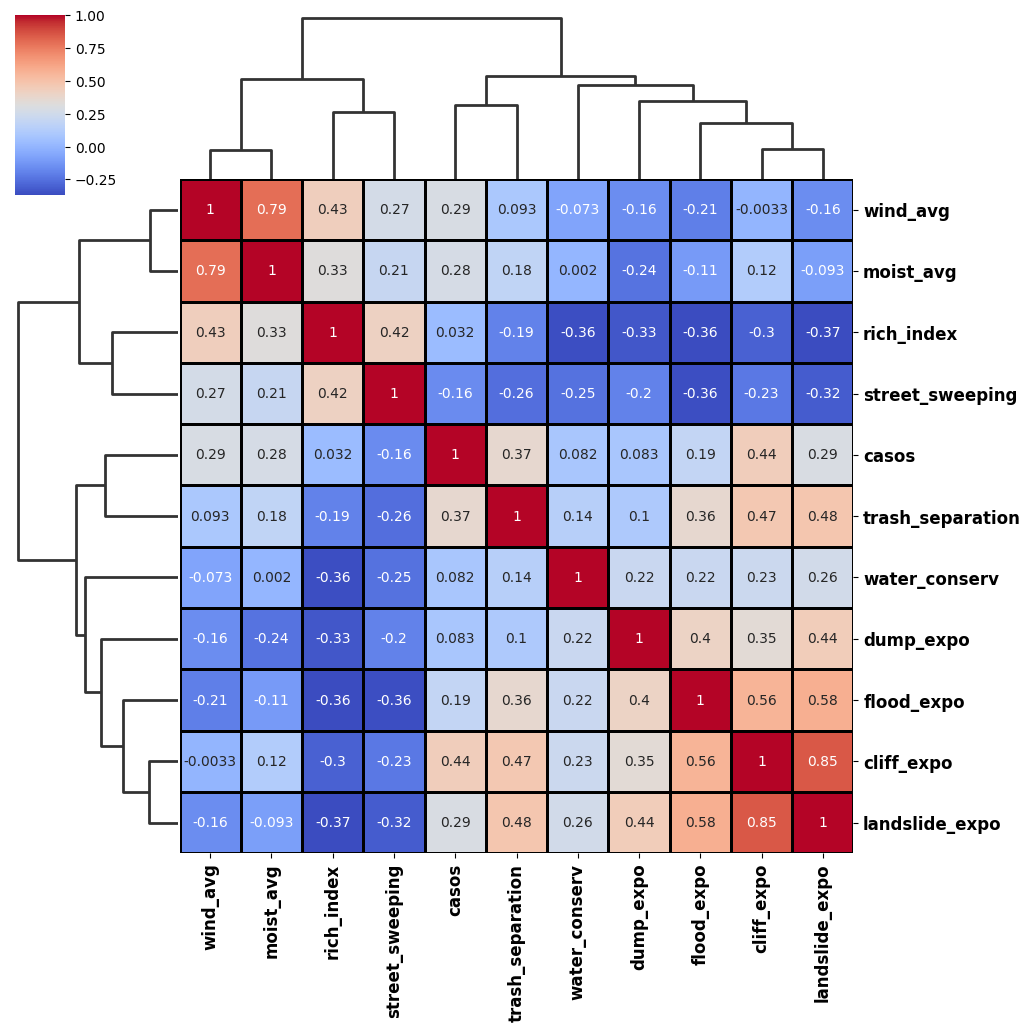

In [104]:
agrupado_full_2 = agrupado_full.drop(columns=['Año','Ubigeo'])
corr_spearman = agrupado_full_2.corr(method='pearson')

# Generar el clustermap
cg = sns.clustermap(corr_spearman, method='weighted', cmap='coolwarm',annot=True, linewidths=1, linecolor='black',dendrogram_ratio=(0.2, 0.2),
               tree_kws={'linewidths': 2})
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=12, fontweight='bold')
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=12, fontweight='bold')

cg

Fit 1 clusters
Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters


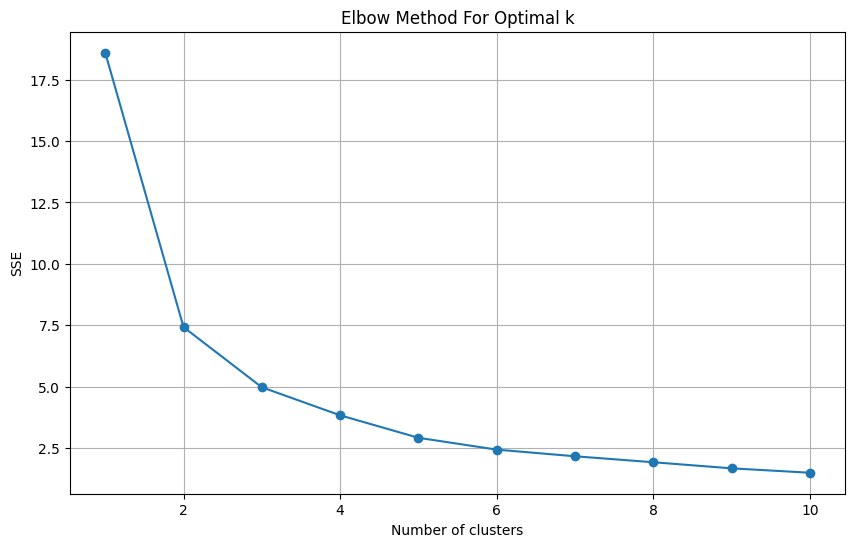

In [105]:
from sklearn.cluster import KMeans
agrupado_full = agrupado_full.loc[agrupado_full['Año']==2024]

labels = agrupado_full.iloc[:,:3]
train_X = agrupado_full.drop(columns=['Año','Ubigeo','casos'])
X = agrupado_full.loc[:,['Año'] + list(agrupado_full.columns)[4:]]

def find_optimal_clusters(data, max_k):
    iters = range(1, max_k+1)
    
    sse = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=50, max_iter=300, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        print(f'Fit {k} clusters')

    plt.figure(figsize=(10, 6))
    plt.plot(iters, sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title('Elbow Method For Optimal k')
    plt.grid(True)
    plt.show()

# Encontrar el número óptimo de clusters
find_optimal_clusters(train_X, 10)



Fit 2 clusters, silhouette score: 0.538258793160095
Fit 3 clusters, silhouette score: 0.502995308957447
Fit 4 clusters, silhouette score: 0.36700793143209864
Fit 5 clusters, silhouette score: 0.39944421100356825
Fit 6 clusters, silhouette score: 0.34035748219043344
Fit 7 clusters, silhouette score: 0.3353420202976458
Fit 8 clusters, silhouette score: 0.3326816466518389
Fit 9 clusters, silhouette score: 0.2682479042117961
Fit 10 clusters, silhouette score: 0.30600477803751935


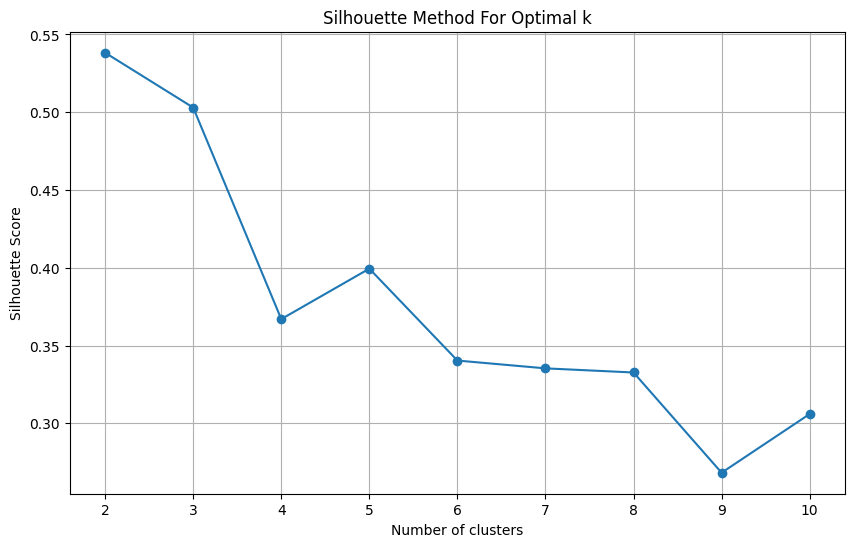

In [106]:
from sklearn.metrics import silhouette_score, silhouette_samples

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1)
    
    silhouette_scores = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init='auto', max_iter=300, random_state=42)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
        print(f'Fit {k} clusters, silhouette score: {score}')
        
    plt.figure(figsize=(10, 6))
    plt.plot(iters, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method For Optimal k')
    plt.grid(True)
    plt.show()

# Encontrar el número óptimo de clusters
find_optimal_clusters(train_X, 10)

In [107]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init='auto', max_iter=300, random_state=42)
agrupado_full['class'] = kmeans.fit_predict(train_X)
agrupado_full['class'].value_counts()

C:\Users\isosc\AppData\Local\Temp\ipykernel_15316\1928329309.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



class
0    34
1    16
Name: count, dtype: int64

In [108]:
only_casos_tf = only_casos.groupby(['Año', 'Ubigeo'], as_index=False).sum()
only_casos_tf.drop(columns=['Semana'],inplace=True)

sql_distritos = pd.read_csv('datasets\sql_distritos.csv')
only_casos_tf['Ubigeo'] = only_casos_tf['Ubigeo'].astype(str)
sql_distritos['Ubigeo'] = sql_distritos['Ubigeo'].astype(str)

gdf1 = pd.merge(left=only_casos_tf,right=sql_distritos,how='left',on='Ubigeo')
gdf1.drop(columns=['Provincia','Diris','Coordenadas','Adyacentes'],inplace=True)
gdf1.columns = list(gdf1.columns)[:-1] + ['geometry']
gdf1['geometry'] = gpd.GeoSeries.from_wkt(gdf1['geometry'])
gdf1 = gpd.GeoDataFrame(gdf1,geometry='geometry')

<>:4: SyntaxWarning:

invalid escape sequence '\s'

<>:4: SyntaxWarning:

invalid escape sequence '\s'

C:\Users\isosc\AppData\Local\Temp\ipykernel_15316\3788857150.py:4: SyntaxWarning:

invalid escape sequence '\s'



In [109]:
gdf1['Año'] = gdf1['Año'].astype('str')
gdf1['Ubigeo'] = gdf1['Ubigeo'].astype('str')
gdf1['casos'] = gdf1['casos'].astype('str')

agrupado_full['Año'] = agrupado_full['Año'].astype('str')
agrupado_full['Ubigeo'] = agrupado_full['Ubigeo'].astype('str')
agrupado_full['casos'] = agrupado_full['casos'].astype('str')

gdf1 = pd.merge(left=gdf1,right=agrupado_full,how='inner',on=['Año','Ubigeo','casos'])
gdf1['casos'] = gdf1['casos'].astype('float')

C:\Users\isosc\AppData\Local\Temp\ipykernel_15316\2818800654.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\isosc\AppData\Local\Temp\ipykernel_15316\2818800654.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\isosc\AppData\Local\Temp\ipykernel_15316\2818800654.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

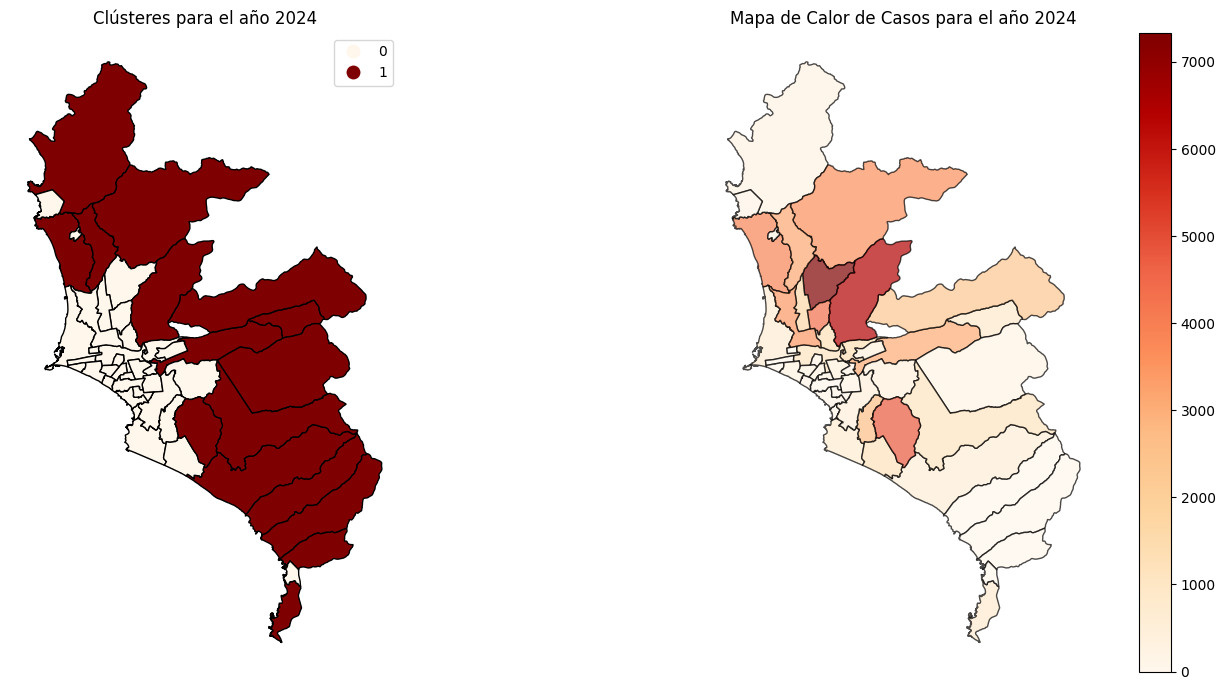

In [132]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_maps(df, year):
    """
    Función para generar dos mapas: uno coloreando los clústeres de la variable 'class'
    y otro mostrando un mapa de calor para la variable 'casos'.

    Parámetros:
    df (GeoDataFrame): DataFrame geoespacial que contiene las columnas 'geometry', 'year', 'class', y 'casos'.
    year (int): Año para el cual se generarán los mapas.
    """

    # Filtrar los datos para el año especificado
    df_year = df[df['Año'] == year]
    df_year['centroid'] = df_year.geometry.centroid

    # Crear una figura con dos subplots
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    # Mapa coloreando los clústeres de la variable 'class'
    df_year.plot(column='class', cmap='OrRd', legend=True, ax=ax[0], edgecolor='black')
    ax[0].set_title(f'Clústeres para el año {year}')
    ax[0].axis('off')

    # Mapa de calor para la variable 'casos'
    df_year.plot(column='casos', cmap='OrRd', legend=True, ax=ax[1], alpha=0.7, edgecolor='black')
    ax[1].set_title(f'Mapa de Calor de Casos para el año {year}')
    ax[1].axis('off')


    # Mostrar los mapas
    plt.tight_layout()
    plt.show()

gdf1['class'] = gdf1['class'].astype(str)
plot_maps(gdf1,'2024')

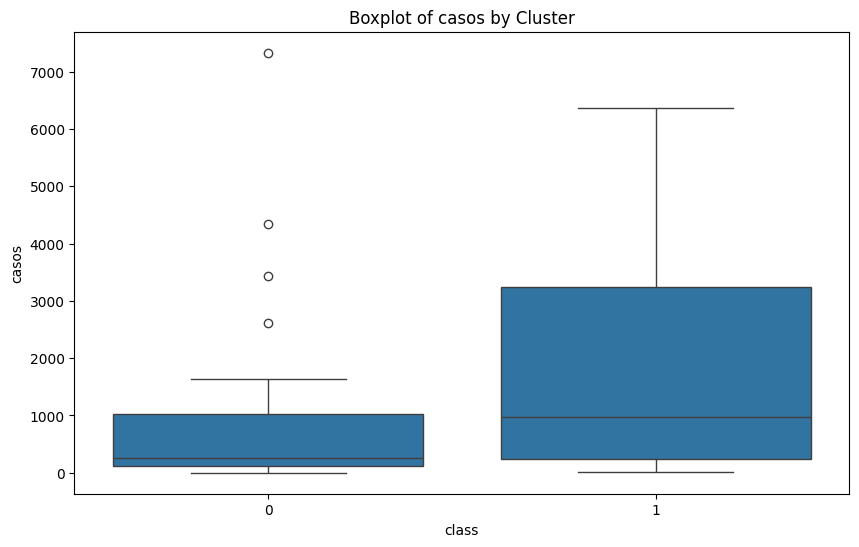

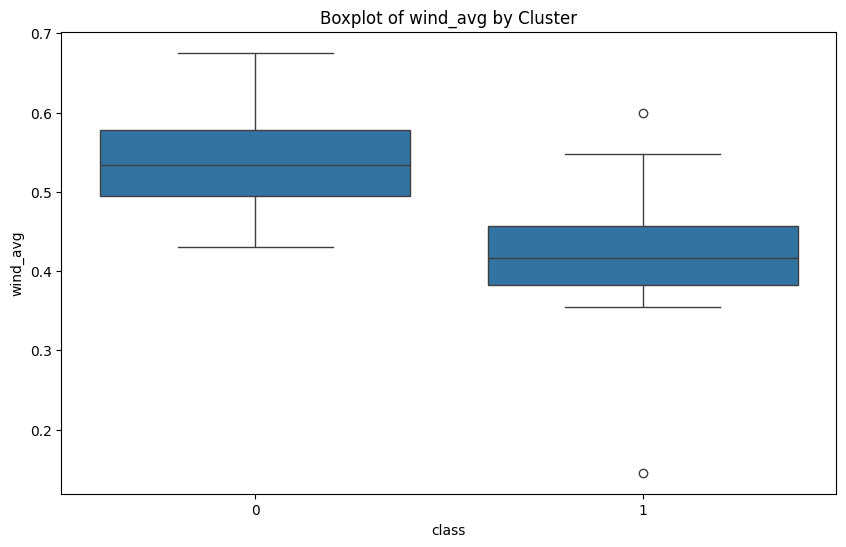

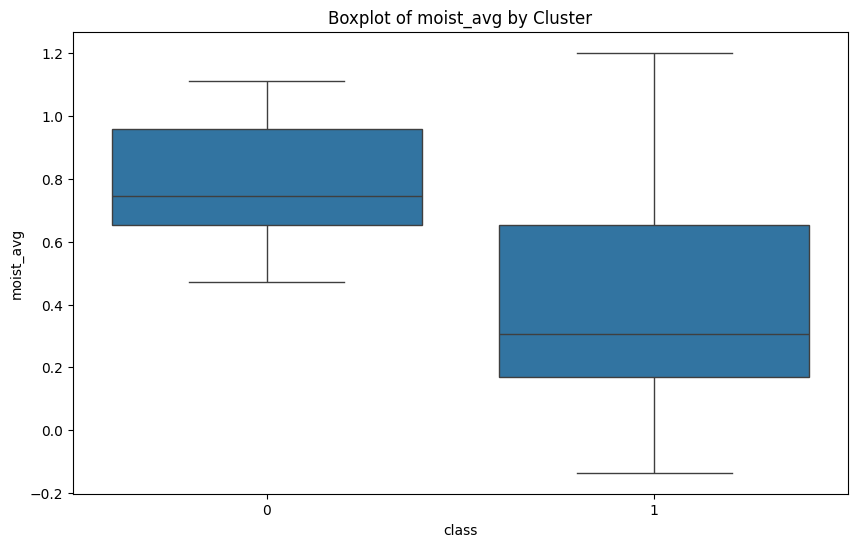

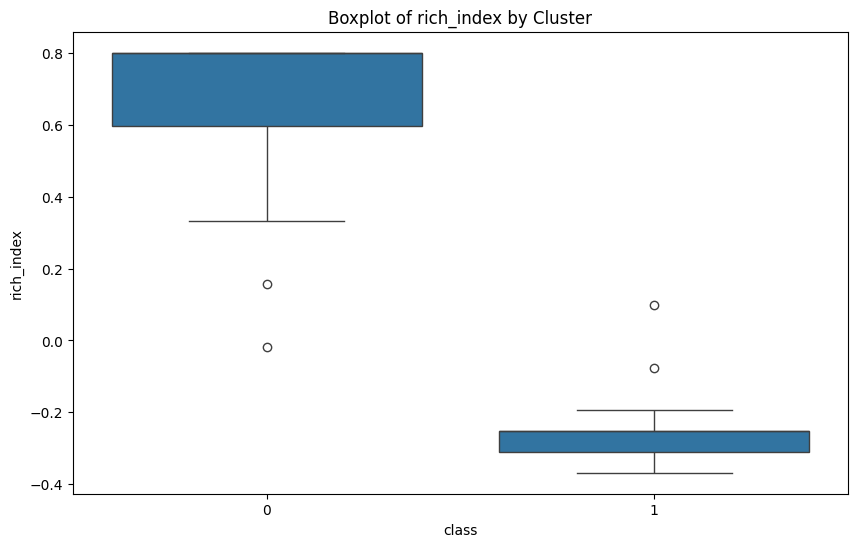

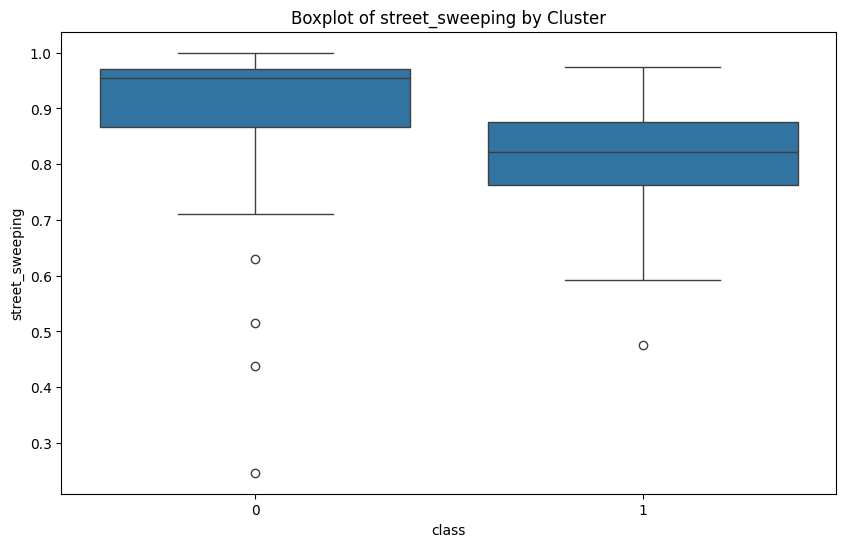

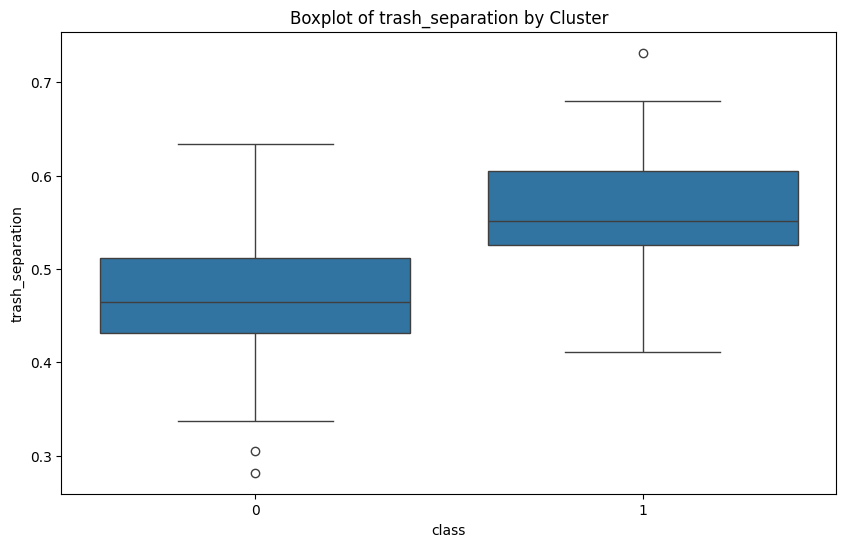

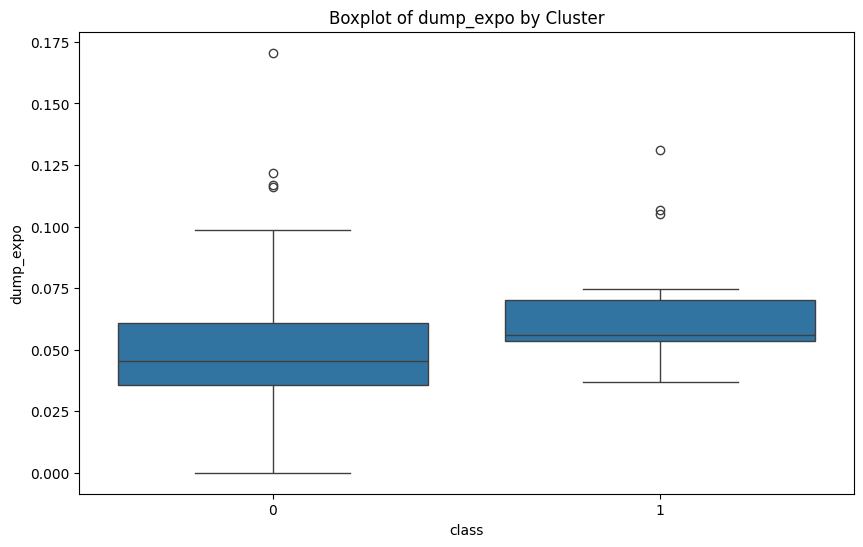

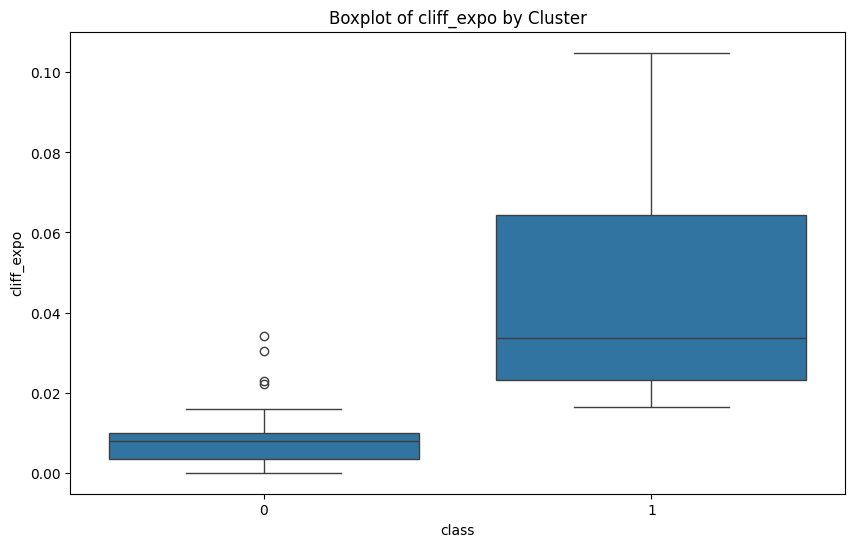

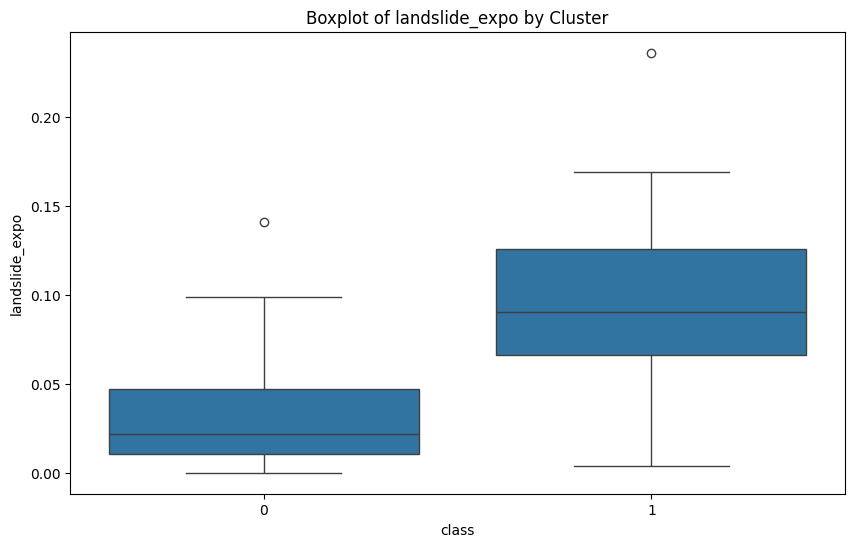

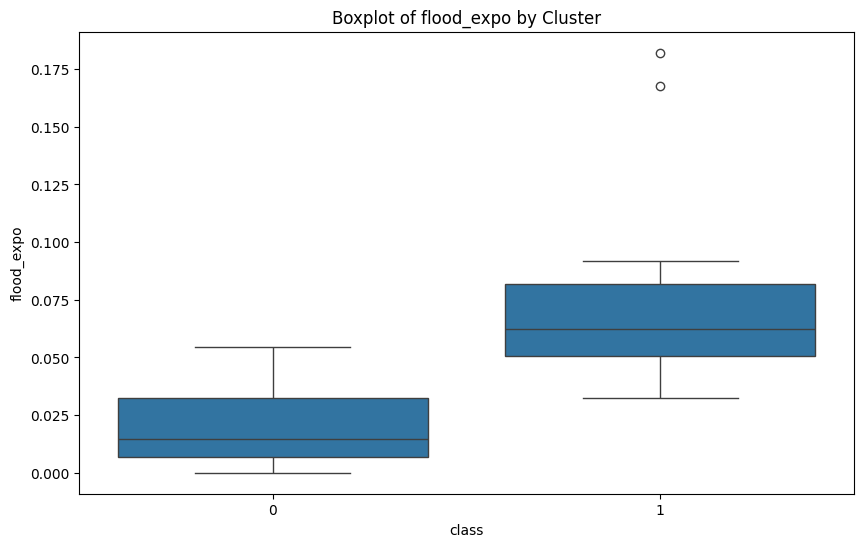

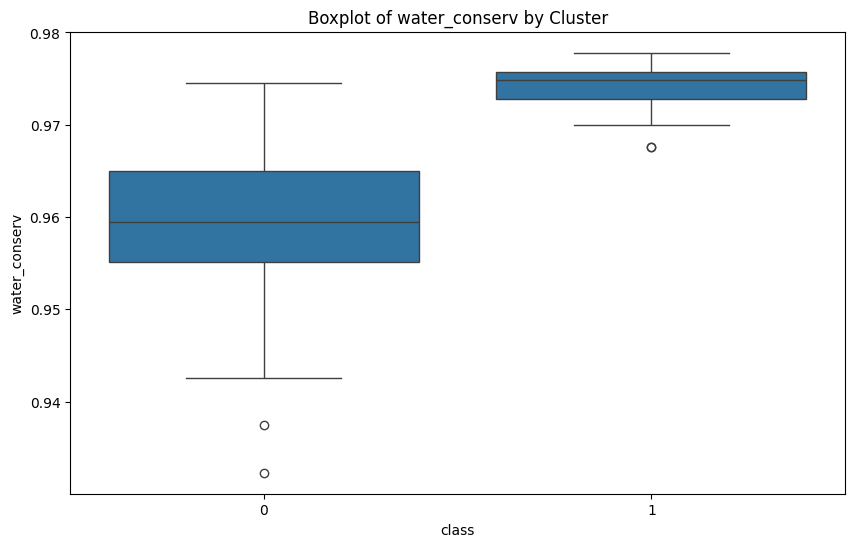

ANOVA for casos: F-value = 4.236121640612651, p-value = 0.045023771915977305
ANOVA for wind_avg: F-value = 28.5884836124846, p-value = 2.451020229924351e-06
ANOVA for moist_avg: F-value = 19.884066337727976, p-value = 4.944098902997833e-05
ANOVA for rich_index: F-value = 243.16167448343148, p-value = 2.0279029332930765e-20
ANOVA for street_sweeping: F-value = 2.871564396156589, p-value = 0.09663671418068835
ANOVA for trash_separation: F-value = 18.23834348889501, p-value = 9.157382478543481e-05
ANOVA for dump_expo: F-value = 1.61841681072902, p-value = 0.20944138766049805
ANOVA for cliff_expo: F-value = 55.19670026429978, p-value = 1.6198762115267486e-09
ANOVA for landslide_expo: F-value = 28.62964577783067, p-value = 2.4186277134511417e-06
ANOVA for flood_expo: F-value = 40.30974544058233, p-value = 7.330415342269038e-08
ANOVA for water_conserv: F-value = 38.89238670794173, p-value = 1.0906723151337912e-07


In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

# Estadísticas descriptivas por clúster
desc2024 = gdf1.drop(columns=['Año','Ubigeo','Distrito','Población','geometry'])

cluster_summary = desc2024.groupby('class').agg(['mean', 'std']).reset_index()

# Histogramas y Boxplots por clúster
for column in desc2024.columns[:-1]:  # Excluye la columna de clúster
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='class', y=column, data=desc2024)
    plt.title(f'Boxplot of {column} by Cluster')
    plt.show()

# Análisis de Varianza (ANOVA)
anova_results = {}
for column in desc2024.columns[:-1]:
    clusters = [desc2024[desc2024['class'] == c][column] for c in desc2024['class'].unique()]
    anova_results[column] = f_oneway(*clusters)

# Mostrar resultados de ANOVA
for column, result in anova_results.items():
    print(f'ANOVA for {column}: F-value = {result.statistic}, p-value = {result.pvalue}')

In [66]:
txt = """ANOVA for casos: F-value = 4.236121640612651, p-value = 0.045023771915977305
ANOVA for wind_avg: F-value = 28.5884836124846, p-value = 2.451020229924351e-06
ANOVA for moist_avg: F-value = 19.884066337727976, p-value = 4.944098902997833e-05
ANOVA for rich_index: F-value = 243.161674483431, p-value = 2.0279029332931574e-20
ANOVA for street_sweeping: F-value = 2.871564396156589, p-value = 0.09663671418068835
ANOVA for trash_separation: F-value = 18.23834348889501, p-value = 9.157382478543481e-05
ANOVA for dump_expo: F-value = 1.61841681072902, p-value = 0.20944138766049805
ANOVA for cliff_expo: F-value = 55.19670026429978, p-value = 1.6198762115267486e-09
ANOVA for landslide_expo: F-value = 28.62964577783067, p-value = 2.4186277134511417e-06
ANOVA for flood_expo: F-value = 40.30974544058233, p-value = 7.330415342269038e-08
ANOVA for water_conserv: F-value = 38.89238670794173, p-value = 1.0906723151337912e-07"""

In [74]:
import re

for line in txt.split('\n'):
    name = re.sub('_',r'\\_',re.findall(r'[\w]+(?=:)',line)[0])
    fvalue = re.findall(r'(?<=F-value = )[\w.]+',line)[0]
    pvalue = re.findall(r'(?<=p-value = )[\w.]+',line)[0]
    
    print(f'{name} & {fvalue} & {pvalue} \\')



casos & 4.236121640612651 & 0.045023771915977305 \
wind\_avg & 28.5884836124846 & 2.451020229924351e \
moist\_avg & 19.884066337727976 & 4.944098902997833e \
rich\_index & 243.161674483431 & 2.0279029332931574e \
street\_sweeping & 2.871564396156589 & 0.09663671418068835 \
trash\_separation & 18.23834348889501 & 9.157382478543481e \
dump\_expo & 1.61841681072902 & 0.20944138766049805 \
cliff\_expo & 55.19670026429978 & 1.6198762115267486e \
landslide\_expo & 28.62964577783067 & 2.4186277134511417e \
flood\_expo & 40.30974544058233 & 7.330415342269038e \
water\_conserv & 38.89238670794173 & 1.0906723151337912e \


Índice de Silhouette promedio: 0.538258793160095


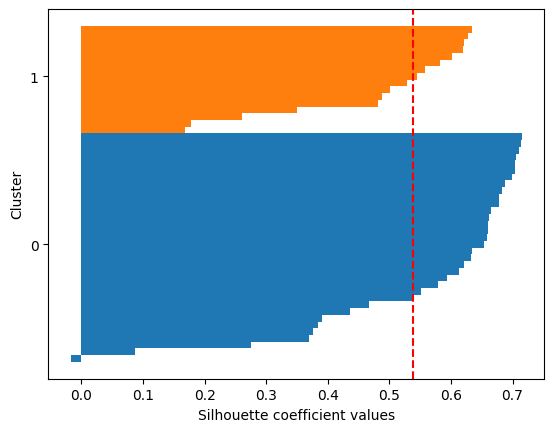

In [113]:
from sklearn.metrics import silhouette_score, silhouette_samples

# Asegúrate de que tus datos no incluyan la columna de etiquetas de clúster al calcular el índice de Silhouette
cluster_labels = gdf1['class']
data_without_labels = gdf1.iloc[:,6:-1]

# Calcular el índice de Silhouette
silhouette_avg = silhouette_score(data_without_labels, cluster_labels)

print(f'Índice de Silhouette promedio: {silhouette_avg}')

# Calcular las puntuaciones de Silhouette para cada muestra
silhouette_vals = silhouette_samples(data_without_labels, cluster_labels)

# Crear un gráfico de Silhouette
y_lower, y_upper = 0, 0
yticks = []

for i, cluster in enumerate(np.unique(cluster_labels)):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    yticks.append((y_lower + y_upper) / 2)
    y_lower += len(cluster_silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, np.unique(cluster_labels))
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient values')
plt.show()

In [117]:
silhouette_vals[cluster_labels=='0']

array([-0.01750327,  0.66012734,  0.69845067,  0.63479359,  0.66099982,
        0.46641388,  0.66550494,  0.66153179,  0.65394987,  0.37581869,
        0.43663275,  0.57852384,  0.63195241,  0.71058901,  0.6779371 ,
        0.53842471,  0.71429566,  0.55088165,  0.71478761,  0.70342488,
        0.70410768,  0.62056601,  0.65897603,  0.70638018,  0.38454702,
        0.59344434,  0.27479562,  0.68848702,  0.36930631,  0.61257657,
        0.39028838,  0.67760602,  0.68359333,  0.08621527])

In [120]:
gdf1

,Año,Ubigeo,casos,Distrito,Población,geometry,wind_avg,moist_avg,rich_index,street_sweeping,trash_separation,dump_expo,cliff_expo,landslide_expo,flood_expo,water_conserv,class
0,2024,70101,676.0,CALLAO,521346.0,"POLYGON ((-77.12995 -11.93682, -77.1299 -11.93...",0.655112,1.049132,-0.017559,0.985902,0.482914,0.116828,0.004357,0.004032,0.041592,0.974562,0
1,2024,70102,64.0,BELLAVISTA,87471.0,"POLYGON ((-77.08767 -12.05191, -77.08768 -12.0...",0.637681,1.049132,0.801842,1.000000,0.398481,0.000000,0.000000,0.000000,0.000000,0.956497,0
2,2024,70103,39.0,CARMEN DE LA LEGUA REYNOSO,48492.0,"POLYGON ((-77.08303 -12.03634, -77.08297 -12.0...",0.607488,0.958036,0.801842,0.972772,0.430249,0.060879,0.005895,0.017754,0.012252,0.962005,0
3,2024,70104,25.0,LA PERLA,70394.0,"POLYGON ((-77.10465 -12.06328, -77.1046 -12.06...",0.649758,1.109862,0.801842,0.958786,0.336629,0.037310,0.000863,0.008394,0.015821,0.955351,0
4,2024,70105,5.0,LA PUNTA,4590.0,"POLYGON ((-77.15878 -12.06647, -77.15875 -12.0...",0.675423,1.049132,0.801842,0.935345,0.439278,0.060787,0.015858,0.053502,0.027584,0.957881,0
5,2024,70106,3840.0,VENTANILLA,347244.0,"POLYGON ((-77.13522 -11.81819, -77.13504 -11.8...",0.599556,0.897306,-0.310202,0.974012,0.659410,0.131262,0.069886,0.169167,0.053814,0.976109,1
6,2024,70107,238.0,MI PERU,50317.0,"POLYGON ((-77.1145 -11.84227, -77.11435 -11.84...",0.538647,0.684750,0.450670,0.937502,0.633495,0.059766,0.007656,0.086553,0.034227,0.963545,0
7,2024,150101,1138.0,LIMA,293647.0,"POLYGON ((-77.00972 -12.03083, -77.00921 -12.0...",0.541729,0.654384,0.684785,0.954489,0.443542,0.081202,0.005790,0.011787,0.009575,0.964511,0
8,2024,150102,250.0,ANCON,69243.0,"POLYGON ((-77.06652 -11.57251, -77.06614 -11.5...",0.433364,0.441828,-0.368730,0.476648,0.628701,0.074817,0.022625,0.070147,0.032600,0.977805,1
9,2024,150103,3071.0,ATE,642828.0,"POLYGON ((-76.83689 -11.9937, -76.83517 -11.99...",0.419780,0.654384,-0.251673,0.908102,0.560890,0.106913,0.104894,0.235912,0.167644,0.975343,1


In [95]:
import plotly.express as px

fig = px.treemap(
    gdf1[gdf1['casos']!=0],
    path=['class','Distrito'],
    values='casos',
    color='casos',
    color_continuous_scale='OrRd',
)

fig.update_traces(marker=dict(cornerradius=5),textinfo='label+text+value')
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

In [96]:
pd.DataFrame(kmeans.cluster_centers_,index=['Cluster 0','Cluster 1'],columns=new_tags[3:])

,wind_avg,moist_avg,rich_index,street_sweeping,trash_separation,dump_expo,cliff_expo,landslide_expo,flood_expo,water_conserv
Cluster 0,0.530962,0.790269,0.916204,0.872182,0.481484,0.058187,0.015682,0.043600,0.028607,0.960926
Cluster 1,0.376620,0.171577,0.661111,0.761205,0.563010,0.058765,0.038898,0.095803,0.076157,0.974094


In [127]:
gdf1['Distrito'] = gdf1['Distrito'].apply(lambda x: x.title())

In [98]:
import statsmodels.api as sm

cases = gdf1.iloc[:,2]
stata = gdf1.iloc[:,6:-1]

X = sm.add_constant(stata)

model = sm.OLS(cases,stata).fit()

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=42)

params = {'max_depth':[None]+np.linspace(start=1, stop=500, num=30,dtype=int).tolist(),
          'n_estimators':np.linspace(start=1, stop=500, num=30,dtype=int).tolist(),
          'min_samples_split':np.linspace(start=2, stop=50, num=30,dtype=int).tolist(),
          'min_samples_leaf':np.linspace(start=1, stop=50, num=30,dtype=int).tolist(),
          'max_features':list(range(2,stata.shape[1]))}

rs = RandomizedSearchCV(estimator=rf,
                        param_distributions=params,
                        n_iter=50,
                        cv=3,
                        random_state=42,
                        n_jobs=-1)

rs.fit(stata,cases)

best_est = rs.best_estimator_

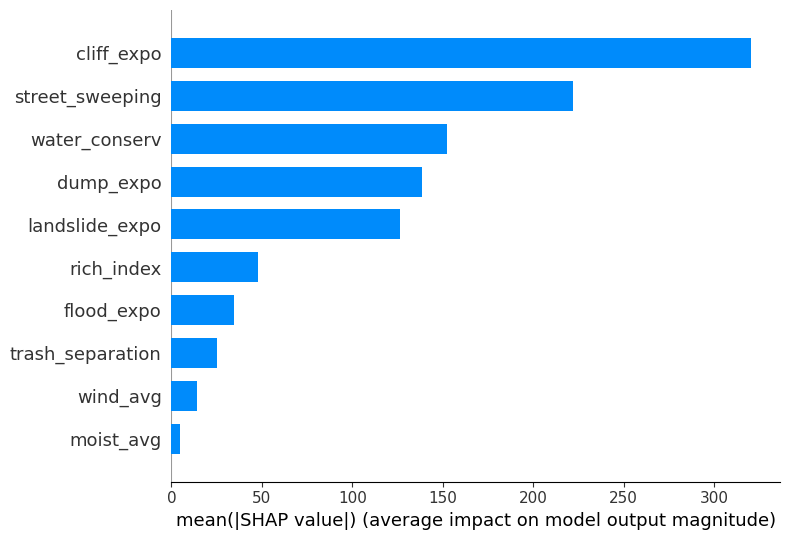

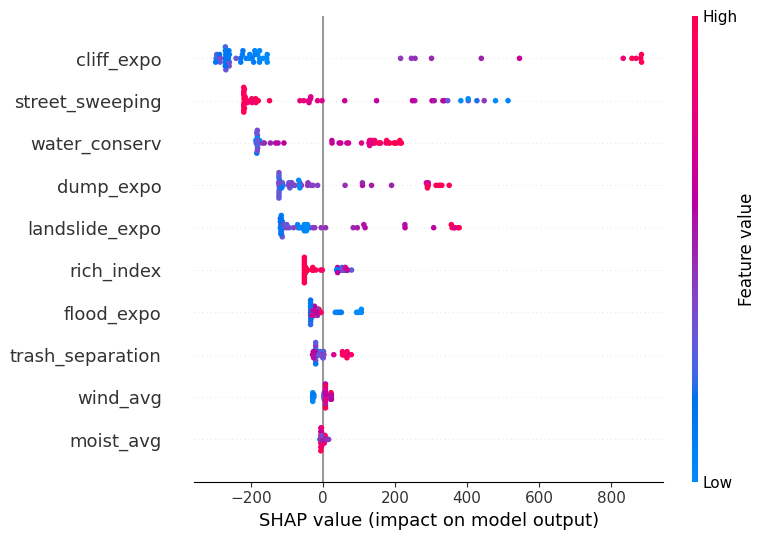

In [100]:
import shap

explainer = shap.TreeExplainer(best_est)
shap_values = explainer.shap_values(stata)

# Crear un resumen de gráfico de SHAP
shap.summary_plot(shap_values, stata, plot_type="bar")
shap.summary_plot(shap_values, stata)